In [1]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

/var/folders/_1/grmv219n3mzbyfj882m03j3c0000gn/T/ipykernel_2610/159884441.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Przygotowanie danych

In [3]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root="data/", train=True, transform=transform, download=True)

# Loading the test set
test_set = FashionMNIST(root="data/", train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([test_set[i][0] for i in range(10,10+num)], dim=0)

# Budowanie autoenkodera wariacyjnego 
VAE tak samo jak zwykły autoenkoder zbudowany jest z enkodera który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z**, oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**

Zacznijmy od stworzenia enkodera

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)                      # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat
        

### Uzupełnij metodę losowania nowych przykładów w przestrzeni ukrytej

Enkodujemy punkt do jakiegoś rozkładu normalnego w przestrzeni. Następnie bierzemy ten punkt i dekodujemy

In [6]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

        
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean) # losujemy jakiś szum z rozkładu normalnego
        z = torch.normal(mean, var) # ~N(mean, var) # Change to proper sampling
        z = mean + eps * var # dodajemy średnią i mnozymy przez wariancję, aby otrzymać punkt z 
        return z
        
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [7]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=784).to(device)

# Możemy zacząć trening

In [8]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [9]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()             
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 8741.815225193643, test L1 = 0.09087012503296137
Epoch 1 loss 4391.83738147703, test L1 = 0.07967716865241528
Epoch 2 loss 3663.267003246862, test L1 = 0.07253502905368805
Epoch 3 loss 3285.742141593216, test L1 = 0.0688102213665843
Epoch 4 loss 3039.449483757345, test L1 = 0.06711587365716695
Epoch 5 loss 2840.599138830462, test L1 = 0.06387643609195948
Epoch 6 loss 2680.741198417468, test L1 = 0.06198085444048047
Epoch 7 loss 2551.1888208633814, test L1 = 0.060065139271318915
Epoch 8 loss 2446.429971287393, test L1 = 0.05907656885683536
Epoch 9 loss 2343.394785823985, test L1 = 0.05740252183750272
Epoch 10 loss 2259.5231490175947, test L1 = 0.05628950167447329
Epoch 11 loss 2193.8028366219282, test L1 = 0.05532890893518925
Epoch 12 loss 2132.1243938217817, test L1 = 0.054617975000292064
Epoch 13 loss 2079.7643437833867, test L1 = 0.053679478168487546
Epoch 14 loss 2037.1128065321182, test L1 = 0.053628986980766055
Epoch 15 loss 1996.7315094776643, test L1 = 0.05245146444

In [10]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


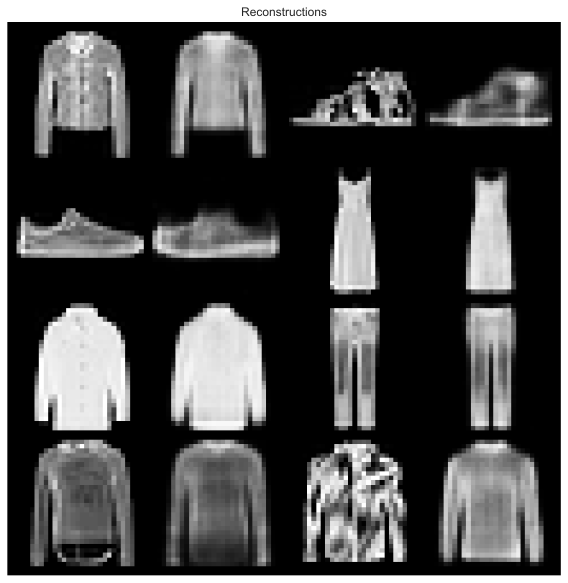

In [11]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [12]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device)) # losujemy z ukrytej przestrzeni jakis punkt
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


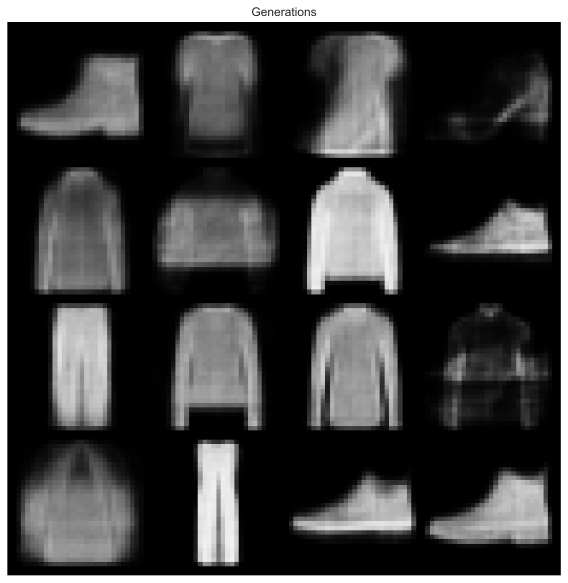

In [18]:
generate_images(vae, 16 , device)

# działa słabo, gdyz przestrzeń ukryta jest bardzo duza i mała szansa ze w coś trafimy. Mozemy to naprawić poprzez regularyzację przestrzeni ukrytej w taki sposób, aby kady przykład miał rozkład N(0, 1).

# (ściskamy, aby punkty były jak najblizej siebie).
# 
# Robimy to poprzez regularyzację, a dokładniej poprzez zmianę funkcji kosztu.

## Co poszło nie tak?

In [33]:
import copy
vae_32 = copy.deepcopy(vae)

In [ ]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [14]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kullback_leiver_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + kullback_leiver_div

In [15]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [16]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 10873.515587439904, test L1 = 0.09850611053407192
Epoch 1 loss 7849.864992321047, test L1 = 0.0947173774242401
Epoch 2 loss 7327.094221587874, test L1 = 0.09107504971325397
Epoch 3 loss 7023.30716020633, test L1 = 0.08865118212997913
Epoch 4 loss 6831.653727213542, test L1 = 0.08749780673533677
Epoch 5 loss 6700.305073534321, test L1 = 0.08692924678325653
Epoch 6 loss 6609.821186815571, test L1 = 0.08560203332453967
Epoch 7 loss 6540.150730752537, test L1 = 0.08486829176545144
Epoch 8 loss 6488.810540614984, test L1 = 0.0839513311162591
Epoch 9 loss 6440.115465995593, test L1 = 0.08304433096200228
Epoch 10 loss 6395.775832999466, test L1 = 0.08358338195830584
Epoch 11 loss 6364.311310596955, test L1 = 0.08324750624597073
Epoch 12 loss 6333.713524973291, test L1 = 0.08205190319567919
Epoch 13 loss 6299.404038127671, test L1 = 0.08081237971782684
Epoch 14 loss 6276.040345803285, test L1 = 0.08097659349441529
Epoch 15 loss 6251.980109842414, test L1 = 0.08053504563868046
Epoc

/Users/Kuba/miniforge3/envs/SSNE/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


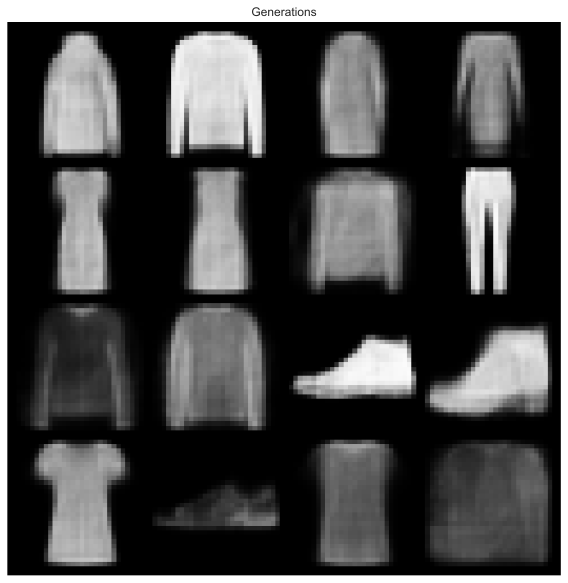

In [17]:
generate_images(vae, 16 , device)

# Przestrzeń ukryta VAE

In [19]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for imgs, label in data_loader:
        with torch.no_grad():
            mean, var_log = model.encoder(imgs.to(device))
        img_list.append(imgs)
        embed_list.append(mean)
        labels.append(label)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0))


In [ ]:
import umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [ ]:
umap_object = umap.UMAP(metric="cosine", n_neighbors=100)
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = umap_object.fit_transform(train_img_embeds[1][:5000].cpu())

In [21]:
def plot_latent(train_embedded, train_img_embeds, n_data=5000):
    data = pd.DataFrame(train_embedded[:n_data])
    data["label"] = train_img_embeds[2][:n_data].cpu().numpy()
    examples = []
    examples_locations = []
    for i in np.random.randint(0,n_data,40):
        examples.append(train_img_embeds[0][i].squeeze(0).cpu().numpy())
        examples_locations.append(data.iloc[i])
    fig, ax = plt.subplots(figsize=(12, 10))
    # ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
    sns.scatterplot(
        x=0, y=1,
        hue="label",
        palette=sns.color_palette("hls", 10),
        data=data,
        legend="full",
        alpha=0.1
    )
    for location, example in zip(examples_locations, examples):
        x, y = location[0], location[1]
        label = int(location["label"])
        ab = AnnotationBbox(OffsetImage(example,cmap=plt.cm.gray_r, zoom=1), (x, y), frameon=True,
                            bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
        ax.add_artist(ab)
    plt.show()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
vae = VAE(latent_dim=2, hidden_dim=256, x_dim=784).to(device)

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
num_epochs = 30
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

In [ ]:
generate_images(vae, 16 , device)

In [ ]:
train_img_embeds = embed_imgs(vae, train_loader)
test_img_embeds = embed_imgs(vae, test_loader)
train_embedded = train_img_embeds[1][:5000].cpu()

In [ ]:
plot_latent(train_embedded, train_img_embeds)

In [ ]:
data = pd.DataFrame(train_embedded[:5000])
data["label"] = train_img_embeds[2][:5000].cpu().numpy()
fig, ax = plt.subplots(figsize=(12, 10))
# ax.scatter(noises_to_plot_tsne[0],noises_to_plot_tsne[1],c=noises_to_plot_tsne["batch"],s=3,alpha=0.8)
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

# Generative Adversarial Networks

Mamy jakiś rozkład, z którego losujemy punkt. Ten punkt podajemy do Generatora, który ma nam coś wygenerować (np. obrazek kota).

Mamy takze drugą sieć, czyli Dyskryminator. Zajmuje się on ocenianiem, czy wygenerowane wyjście przez Generator jest obrazem prawdziwym czy tez nie.

Uczymy 2 sieci:
- Generator na podstawie wyjść Dyskryminatora, które mówią, jak dobrze wygenerowany jest obraz.
- Dyskryminator - uczy się coraz lepiej oceniać wejście generatora.

In [23]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out  = nn.Linear(hidden_dim, 1)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        x = self.fc_out(x)
        return x

In [24]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))
        
        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

In [25]:
# Models
latent_dim = 32
generator = Generator(latent_dim=latent_dim, hidden_dim=256, output_dim=784).to(device)
discriminator = Discriminator( hidden_dim=256, input_dim=784).to(device)

# Optimizers
# 2 niezalezne optymalizatory - dla generatora i dla dyskryminatora
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [26]:
fixed_noise = torch.randn(16, latent_dim,device=device)

Uczymy na zmianę generator i dyskryminator

Epoch: 0, discrimiantor fake error: 0.0595, discriminator real acc: 0.841


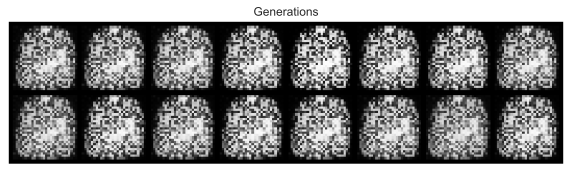

Epoch: 1, discrimiantor fake error: 0.0296, discriminator real acc: 0.946
Epoch: 2, discrimiantor fake error: 0.0201, discriminator real acc: 0.962
Epoch: 3, discrimiantor fake error: 0.00754, discriminator real acc: 0.98
Epoch: 4, discrimiantor fake error: 0.0022, discriminator real acc: 0.991
Epoch: 5, discrimiantor fake error: 0.00177, discriminator real acc: 0.995
Epoch: 6, discrimiantor fake error: 0.00172, discriminator real acc: 0.997
Epoch: 7, discrimiantor fake error: 0.00217, discriminator real acc: 0.997
Epoch: 8, discrimiantor fake error: 0.0066, discriminator real acc: 0.995
Epoch: 9, discrimiantor fake error: 0.0205, discriminator real acc: 0.985
Epoch: 10, discrimiantor fake error: 0.0267, discriminator real acc: 0.975


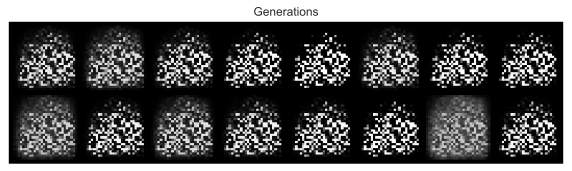

Epoch: 11, discrimiantor fake error: 0.0173, discriminator real acc: 0.978
Epoch: 12, discrimiantor fake error: 0.00831, discriminator real acc: 0.988
Epoch: 13, discrimiantor fake error: 0.00872, discriminator real acc: 0.991
Epoch: 14, discrimiantor fake error: 0.0238, discriminator real acc: 0.981
Epoch: 15, discrimiantor fake error: 0.0388, discriminator real acc: 0.967
Epoch: 16, discrimiantor fake error: 0.0225, discriminator real acc: 0.974
Epoch: 17, discrimiantor fake error: 0.017, discriminator real acc: 0.981
Epoch: 18, discrimiantor fake error: 0.0195, discriminator real acc: 0.982
Epoch: 19, discrimiantor fake error: 0.0255, discriminator real acc: 0.976
Epoch: 20, discrimiantor fake error: 0.0252, discriminator real acc: 0.978


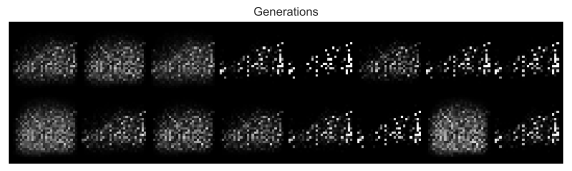

Epoch: 21, discrimiantor fake error: 0.0261, discriminator real acc: 0.974
Epoch: 22, discrimiantor fake error: 0.0255, discriminator real acc: 0.975
Epoch: 23, discrimiantor fake error: 0.0242, discriminator real acc: 0.973
Epoch: 24, discrimiantor fake error: 0.0209, discriminator real acc: 0.977
Epoch: 25, discrimiantor fake error: 0.0193, discriminator real acc: 0.978
Epoch: 26, discrimiantor fake error: 0.0249, discriminator real acc: 0.975
Epoch: 27, discrimiantor fake error: 0.0228, discriminator real acc: 0.974
Epoch: 28, discrimiantor fake error: 0.0226, discriminator real acc: 0.975
Epoch: 29, discrimiantor fake error: 0.022, discriminator real acc: 0.975
Epoch: 30, discrimiantor fake error: 0.0243, discriminator real acc: 0.974


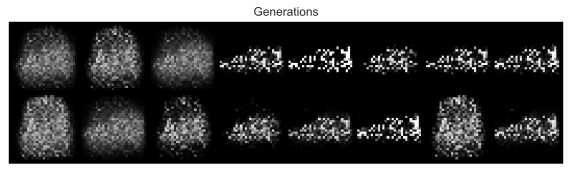

Epoch: 31, discrimiantor fake error: 0.0293, discriminator real acc: 0.969
Epoch: 32, discrimiantor fake error: 0.0345, discriminator real acc: 0.964
Epoch: 33, discrimiantor fake error: 0.0358, discriminator real acc: 0.965
Epoch: 34, discrimiantor fake error: 0.0339, discriminator real acc: 0.965
Epoch: 35, discrimiantor fake error: 0.0257, discriminator real acc: 0.971
Epoch: 36, discrimiantor fake error: 0.0239, discriminator real acc: 0.976
Epoch: 37, discrimiantor fake error: 0.0254, discriminator real acc: 0.975
Epoch: 38, discrimiantor fake error: 0.0286, discriminator real acc: 0.972
Epoch: 39, discrimiantor fake error: 0.0286, discriminator real acc: 0.972
Epoch: 40, discrimiantor fake error: 0.0245, discriminator real acc: 0.976


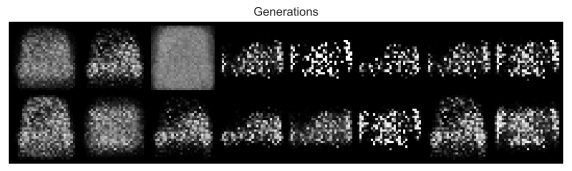

Epoch: 41, discrimiantor fake error: 0.0291, discriminator real acc: 0.971
Epoch: 42, discrimiantor fake error: 0.0307, discriminator real acc: 0.971
Epoch: 43, discrimiantor fake error: 0.0287, discriminator real acc: 0.97
Epoch: 44, discrimiantor fake error: 0.0312, discriminator real acc: 0.968
Epoch: 45, discrimiantor fake error: 0.0307, discriminator real acc: 0.968
Epoch: 46, discrimiantor fake error: 0.0299, discriminator real acc: 0.969
Epoch: 47, discrimiantor fake error: 0.0391, discriminator real acc: 0.965
Epoch: 48, discrimiantor fake error: 0.0388, discriminator real acc: 0.96
Epoch: 49, discrimiantor fake error: 0.0331, discriminator real acc: 0.967
Epoch: 50, discrimiantor fake error: 0.035, discriminator real acc: 0.968


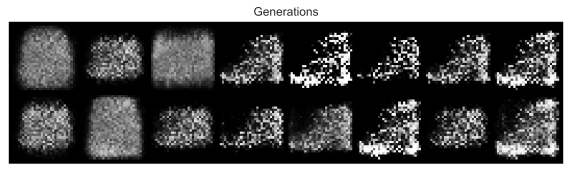

Epoch: 51, discrimiantor fake error: 0.0366, discriminator real acc: 0.966
Epoch: 52, discrimiantor fake error: 0.0337, discriminator real acc: 0.966
Epoch: 53, discrimiantor fake error: 0.0335, discriminator real acc: 0.967
Epoch: 54, discrimiantor fake error: 0.0342, discriminator real acc: 0.968
Epoch: 55, discrimiantor fake error: 0.0317, discriminator real acc: 0.968
Epoch: 56, discrimiantor fake error: 0.0333, discriminator real acc: 0.967
Epoch: 57, discrimiantor fake error: 0.0311, discriminator real acc: 0.97
Epoch: 58, discrimiantor fake error: 0.0338, discriminator real acc: 0.968
Epoch: 59, discrimiantor fake error: 0.0386, discriminator real acc: 0.963
Epoch: 60, discrimiantor fake error: 0.0392, discriminator real acc: 0.963


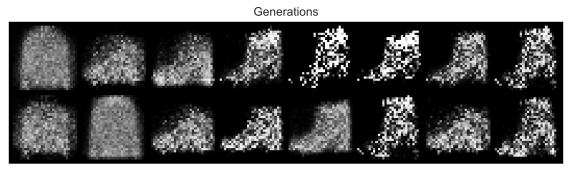

Epoch: 61, discrimiantor fake error: 0.038, discriminator real acc: 0.963
Epoch: 62, discrimiantor fake error: 0.039, discriminator real acc: 0.963
Epoch: 63, discrimiantor fake error: 0.0458, discriminator real acc: 0.961
Epoch: 64, discrimiantor fake error: 0.0354, discriminator real acc: 0.962
Epoch: 65, discrimiantor fake error: 0.039, discriminator real acc: 0.961
Epoch: 66, discrimiantor fake error: 0.0404, discriminator real acc: 0.964
Epoch: 67, discrimiantor fake error: 0.0431, discriminator real acc: 0.955
Epoch: 68, discrimiantor fake error: 0.044, discriminator real acc: 0.957
Epoch: 69, discrimiantor fake error: 0.0488, discriminator real acc: 0.952
Epoch: 70, discrimiantor fake error: 0.0511, discriminator real acc: 0.95


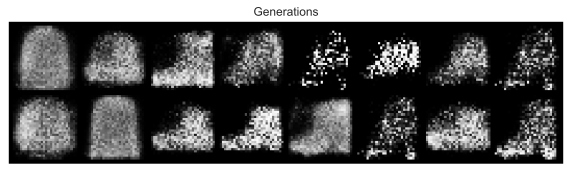

Epoch: 71, discrimiantor fake error: 0.0531, discriminator real acc: 0.946
Epoch: 72, discrimiantor fake error: 0.0585, discriminator real acc: 0.941
Epoch: 73, discrimiantor fake error: 0.0598, discriminator real acc: 0.937
Epoch: 74, discrimiantor fake error: 0.06, discriminator real acc: 0.942
Epoch: 75, discrimiantor fake error: 0.0636, discriminator real acc: 0.933
Epoch: 76, discrimiantor fake error: 0.0698, discriminator real acc: 0.93
Epoch: 77, discrimiantor fake error: 0.0673, discriminator real acc: 0.935
Epoch: 78, discrimiantor fake error: 0.0727, discriminator real acc: 0.923
Epoch: 79, discrimiantor fake error: 0.0692, discriminator real acc: 0.931
Epoch: 80, discrimiantor fake error: 0.0646, discriminator real acc: 0.934


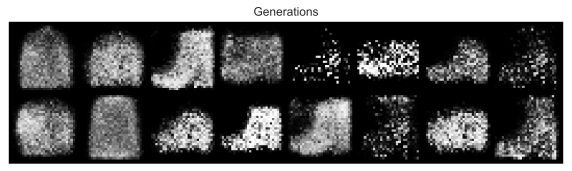

Epoch: 81, discrimiantor fake error: 0.0718, discriminator real acc: 0.93
Epoch: 82, discrimiantor fake error: 0.0695, discriminator real acc: 0.929
Epoch: 83, discrimiantor fake error: 0.0727, discriminator real acc: 0.924
Epoch: 84, discrimiantor fake error: 0.0721, discriminator real acc: 0.926
Epoch: 85, discrimiantor fake error: 0.0763, discriminator real acc: 0.927
Epoch: 86, discrimiantor fake error: 0.0802, discriminator real acc: 0.922
Epoch: 87, discrimiantor fake error: 0.083, discriminator real acc: 0.914
Epoch: 88, discrimiantor fake error: 0.0866, discriminator real acc: 0.917
Epoch: 89, discrimiantor fake error: 0.0945, discriminator real acc: 0.907
Epoch: 90, discrimiantor fake error: 0.0904, discriminator real acc: 0.911


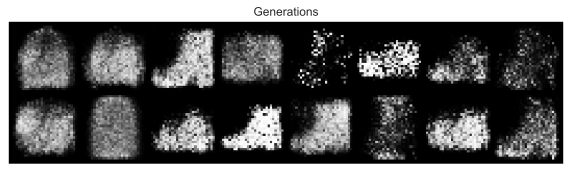

Epoch: 91, discrimiantor fake error: 0.0862, discriminator real acc: 0.909
Epoch: 92, discrimiantor fake error: 0.09, discriminator real acc: 0.912
Epoch: 93, discrimiantor fake error: 0.0893, discriminator real acc: 0.912
Epoch: 94, discrimiantor fake error: 0.096, discriminator real acc: 0.908
Epoch: 95, discrimiantor fake error: 0.0961, discriminator real acc: 0.899
Epoch: 96, discrimiantor fake error: 0.0913, discriminator real acc: 0.903
Epoch: 97, discrimiantor fake error: 0.0932, discriminator real acc: 0.913
Epoch: 98, discrimiantor fake error: 0.0875, discriminator real acc: 0.91
Epoch: 99, discrimiantor fake error: 0.0945, discriminator real acc: 0.9


In [27]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device) # generujemy szum
        # Generate fake image batch with Generator
        fake_images = generator(noise) # przepuszczamy szum przez generator
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1) # przepuszczmy wynik generstora przez dyskryminator
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step() # step tylko dla optymalizatorze dyskryminatora

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Stwórzmy model warunkowany klasą
Może się przydać F.one_hot

# Ewaluacja modeli generatywnych

Tworzymy nową sieć do klasyfikacji, uczymy ją na zbiorze treningowym.

Po wytrenowaniu takiego modelu, mozemy przepuścić wyjścia GANa przez taki model, i zobaczyć, czy cechy wyciągnięte przez ten model (feature extractor) są podobne do tych, które wyciągał na danych treningowych.

Mozemy policzyć róznice w dystrybucji cech.

In [28]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x) # feature extraction
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [29]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [30]:
num_epochs = 7
for epoch in range(num_epochs):
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [31]:
num_correct = 0
total_guesses = 0

evaluator.eval()
with torch.no_grad():
    for data, targets in iter(test_loader):
        # Sends data and targets to device
        data = data.to(device)
        targets = targets.to(device)

        # Acquires the network's best guesses at each class
        results = evaluator(data)
        best_guesses = torch.argmax(results, 1)

        # Updates number of correct and total guesses
        num_correct += torch.eq(targets, best_guesses).sum().item()
        total_guesses += len(targets)

print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")

Correctly guessed  87.16000000000001 % of the dataset


In [34]:
vae = vae_32

Teraz aplikujemy nasz feature extrector z Evaluatora na danych wygenerowanych przez GAN.

Porównujemy cechy z oryginalnego datasetu i z GANa.

In [36]:
with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim,device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
    generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

In [37]:
orig_data = [x[0] for x in list(test_set)[:1000]]
orig_data = torch.cat(orig_data)

In [ ]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()
    dist_cond_gan = evaluator.get_features(generations_cond_gan.to(device)).cpu()

In [ ]:
for idx in range(5):
    bins = 10
    w = 0.3
    plt.figure(figsize=(10,10))
    plt.hist([dist_orig_data[:,idx].numpy(),dist_vae[:,idx].numpy(),dist_gan[:,idx], dist_cond_gan[:,idx]], bins, alpha=0.5, label=['orig','vae','gan','cond_gan'],width=w)
    plt.legend(loc='upper right')
    plt.show();
    plt.close()

In [40]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid
# Odległość pomiędzy dystrybucjami cech - z tego korzystamy przy ewaluacji

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [41]:
orig_data_2 = [x[0] for x in list(test_set)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

In [ ]:
for name, obj in zip(['orig','vae','gan','cond_gan'],[dist_orig_data_2.numpy(),dist_vae.numpy(),dist_gan.numpy(), dist_cond_gan.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")